In [23]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

In [24]:
import numpy as np
import matplotlib.pyplot as plt

In [25]:
!pip install deepxde

In [26]:
import deepxde as dde
from deepxde.backend import tf

geom = dde.geometry.Interval(0, 1)

This defines the geometric domain over which the differential equation will be solved. Specifically, this is a 1D interval from 0 to 1.

    1. dde.geometry.Interval(start, end): Represents a 1D domain with bounds [start, end].
    2. This is typically used to specify the spatial domain for the problem.

Compiling model...
Building feed-forward neural network...
'build' took 0.075411 s

'compile' took 0.434432 s

Training model...

Step      Train loss    Test loss     Test metric   
0         [4.27e-01]    [4.18e-01]    [1.01e+00]    
1000      [1.56e-02]    [2.04e-02]    [2.23e-01]    
2000      [7.32e-06]    [1.18e-02]    [1.70e-01]    
3000      [2.03e-10]    [1.17e-02]    [1.69e-01]    
4000      [1.08e-06]    [1.17e-02]    [1.69e-01]    
5000      [2.03e-06]    [1.17e-02]    [1.69e-01]    
6000      [6.28e-07]    [1.16e-02]    [1.68e-01]    
7000      [3.01e-05]    [1.15e-02]    [1.68e-01]    
8000      [2.97e-10]    [1.15e-02]    [1.67e-01]    
9000      [5.06e-09]    [1.14e-02]    [1.67e-01]    
10000     [2.57e-07]    [1.13e-02]    [1.66e-01]    

Best model at step 3000:
  train loss: 2.03e-10
  test loss: 1.17e-02
  test metric: [1.69e-01]

'train' took 16.078079 s

Saving loss history to /content/loss.dat ...
Saving training data to /content/train.dat ...
Saving test data t

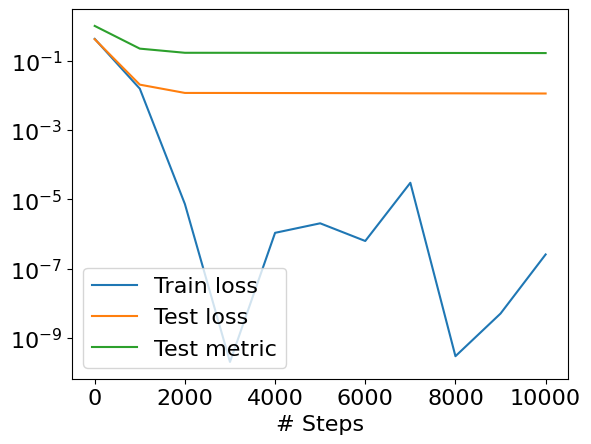

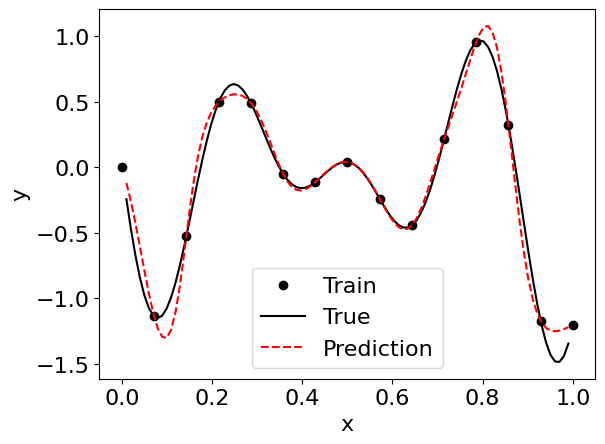

In [27]:
# NN
def func(x):
    return -(1.4 - 3 * x) * np.sin(18 * x)

def NNfunc(x, y):
    return y + (1.4 - 3 * x) * tf.sin(18 * x)


geom = dde.geometry.Interval(0, 1)
data = dde.data.PDE(geom, NNfunc, [], 13, 2, "uniform", solution=func, num_test=100)

activation = "tanh"
initializer = "Glorot uniform"
net = dde.maps.FNN([1] + [20] * 3 + [1], activation, initializer)

NNmodel = dde.Model(data, net)
NNmodel.compile("adam", lr=0.001, metrics=["l2 relative error"])
losshistory, train_state = NNmodel.train(epochs=10000)

dde.saveplot(losshistory, train_state, issave=True, isplot=True)

## **The command dy_x = dde.grad.jacobian(y, x) in the context of a DeepXDE (Deep Learning for Solving Differential Equations) code computes the Jacobian of a function y with respect to x.**

Compiling model...
Building feed-forward neural network...
'build' took 0.342458 s

'compile' took 2.248580 s

Training model...

Step      Train loss              Test loss               Test metric   
0         [4.27e-01, 1.48e+00]    [4.18e-01, 1.12e+00]    [1.01e+00]    
1000      [7.06e-04, 5.04e-04]    [3.19e-04, 5.37e-03]    [2.79e-02]    
2000      [1.14e-04, 4.07e-05]    [6.72e-05, 1.02e-03]    [1.28e-02]    
3000      [3.25e-05, 7.61e-06]    [2.40e-05, 4.51e-04]    [7.66e-03]    
4000      [1.70e-05, 3.95e-06]    [1.48e-05, 2.88e-04]    [6.02e-03]    
5000      [9.93e-06, 2.33e-06]    [1.02e-05, 2.07e-04]    [5.00e-03]    
6000      [5.96e-06, 1.50e-06]    [7.50e-06, 1.62e-04]    [4.28e-03]    
7000      [5.11e-06, 2.16e-06]    [7.43e-06, 1.40e-04]    [4.26e-03]    
8000      [2.35e-05, 6.94e-05]    [2.37e-05, 1.91e-04]    [7.61e-03]    
9000      [6.36e-06, 1.29e-05]    [8.94e-06, 1.30e-04]    [4.67e-03]    
10000     [1.97e-06, 9.37e-07]    [4.72e-06, 1.14e-04]    [3.40e-03

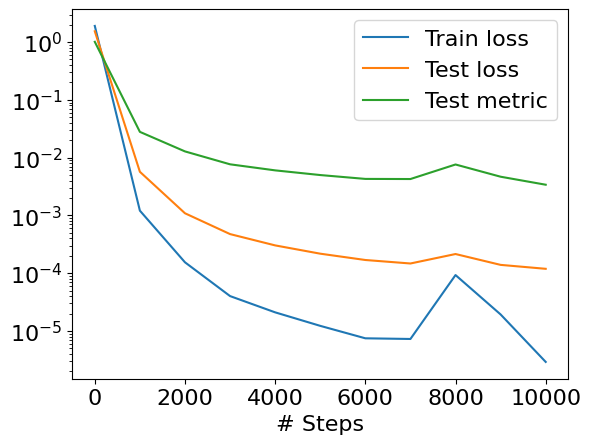

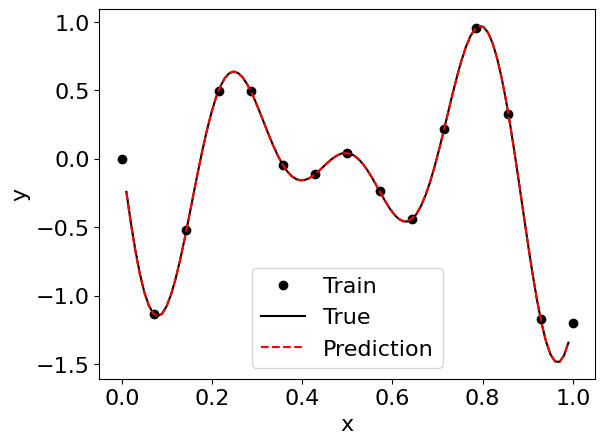

In [28]:
# gNN
def gNNfunc(x, y):
    dy_x = dde.grad.jacobian(y, x)

    return [
        y + (1.4 - 3 * x) * tf.sin(18 * x),
        dy_x + 18 * (1.4 - 3 * x) * tf.cos(18 * x) - 3 * tf.sin(18 * x)]


geom = dde.geometry.Interval(0, 1)
data = dde.data.PDE(geom, gNNfunc, [], 13, 2, "uniform", solution=func, num_test=100)

activation = "tanh"
initializer = "Glorot uniform"
net = dde.maps.FNN([1] + [20] * 3 + [1], activation, initializer)

gNNmodel = dde.Model(data, net)
gNNmodel.compile("adam", lr=0.001, metrics=["l2 relative error"], loss_weights=[1, 0.01])
losshistory, train_state = gNNmodel.train(epochs=10000)

dde.saveplot(losshistory, train_state, issave=True, isplot=True)

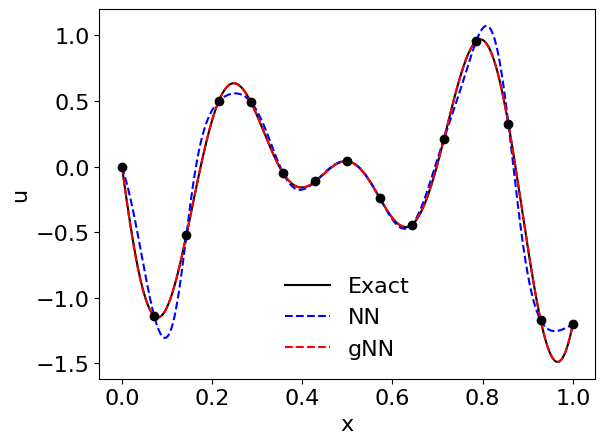

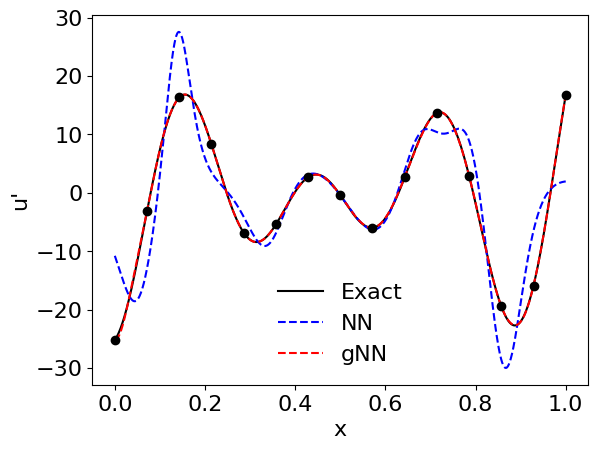

In [29]:
# plots

plt.rcParams.update({"font.size": 16})

x = geom.uniform_points(1000)
plt.figure()
plt.plot(x, func(x), label="Exact", color="black")
plt.plot(x, NNmodel.predict(x), label="NN", color="blue", linestyle="dashed")
plt.plot(x, gNNmodel.predict(x), label="gNN", color="red", linestyle="dashed")

x = geom.uniform_points(15)
plt.plot(x, func(x), color="black", marker="o", linestyle="none")

plt.xlabel("x")
plt.ylabel("u")

plt.legend(frameon=False)


def du_x(x):
    return 3 * np.sin(18 * x) + 18 * (3 * x - 1.4) * np.cos(18 * x)


x = geom.uniform_points(1000)
plt.figure()
plt.plot(x, du_x(x), label="Exact", color="black")
plt.plot(
    x,
    NNmodel.predict(x, operator=lambda x, y: dde.grad.jacobian(y, x)),
    label="NN",
    color="blue",
    linestyle="dashed",
)
plt.plot(
    x,
    gNNmodel.predict(x, operator=lambda x, y: dde.grad.jacobian(y, x)),
    label="gNN",
    color="red",
    linestyle="dashed",
)

x = geom.uniform_points(15)
plt.plot(x, du_x(x), color="black", marker="o", linestyle="none")
plt.xlabel("x")
plt.ylabel("u'")

plt.legend(frameon=False)

plt.show()